In [102]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [103]:
BATCH_SIZE = 48
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=40

In [104]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato_not_use",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15923 files belonging to 10 classes.


In [105]:
class_names = dataset.class_names
class_names 

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [106]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [107]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [108]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [109]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [110]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
data_augmentation.build(input_shape=input_shape)

In [111]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
267/267 [==============================] - 554s 2s/step - loss: 1.5390 - accuracy: 0.4469 - val_loss: 0.8433 - val_accuracy: 0.7001
Epoch 2/40
267/267 [==============================] - 529s 2s/step - loss: 0.7179 - accuracy: 0.7485 - val_loss: 0.5511 - val_accuracy: 0.8112
Epoch 3/40
267/267 [==============================] - 514s 2s/step - loss: 0.4860 - accuracy: 0.8305 - val_loss: 0.4001 - val_accuracy: 0.8586
Epoch 4/40
267/267 [==============================] - 509s 2s/step - loss: 0.3994 - accuracy: 0.8586 - val_loss: 0.3281 - val_accuracy: 0.8832
Epoch 5/40
267/267 [==============================] - 508s 2s/step - loss: 0.3099 - accuracy: 0.8914 - val_loss: 0.2533 - val_accuracy: 0.9097
Epoch 6/40
267/267 [==============================] - 509s 2s/step - loss: 0.2534 - accuracy: 0.9097 - val_loss: 0.1687 - val_accuracy: 0.9457
Epoch 7/40
267/267 [==============================] - 508s 2s/step - loss: 0.2235 - accuracy: 0.9201 - val_loss: 0.2210 - val_accuracy: 0.9236

In [24]:
scores = model.evaluate(test_ds)

34/34 [==============================] - 15s 443ms/step - loss: 0.0449 - accuracy: 0.9888


In [128]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


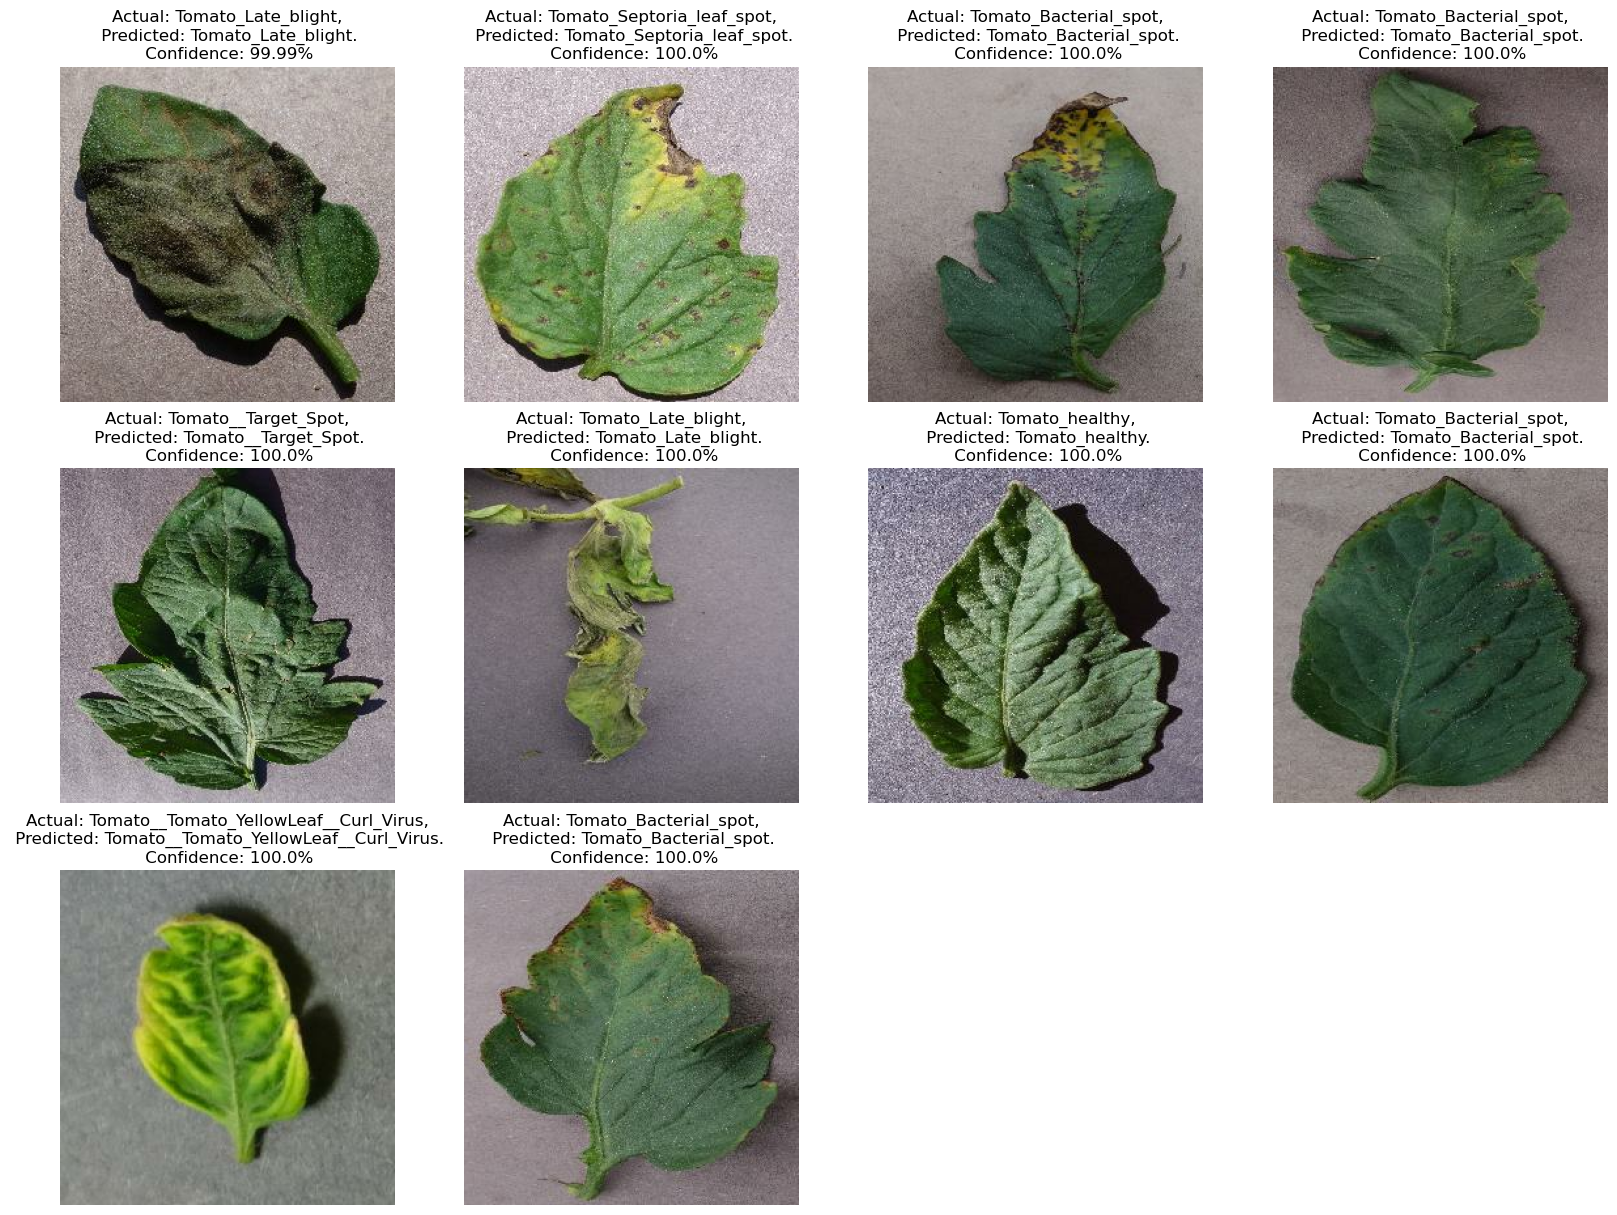

In [132]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(10):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [124]:
model_version = 1
model.save(f"tomatomo_model")

INFO:tensorflow:Assets written to: tomatomo_model\assets


INFO:tensorflow:Assets written to: tomatomo_model\assets


1/1 [==============================] - 0s 367ms/step
0.1025464
0.096863635
0.09864301
0.104596555
0.101923354
0.098367885
0.10096977
0.09916009
0.09944845
0.0974808
1/1 [==============================] - 0s 26ms/step
Tomato_Leaf_Mold


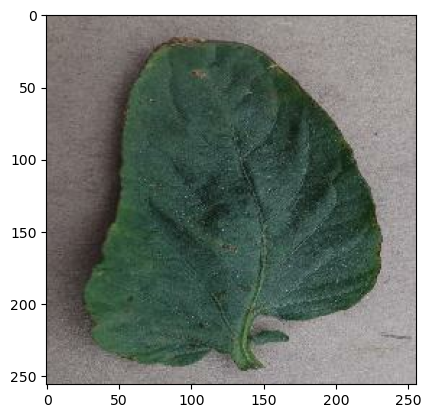

In [116]:
for temp,moo in test_ds.take(1):    
    plt.imshow(temp[2].numpy().astype("uint8"))
    img_array = tf.keras.preprocessing.image.img_to_array(temp[2].numpy())
    img_array = tf.expand_dims(img_array, 0)
    for i in model.predict(img_array):
        for j in i:
            print(j)
    print(class_names[np.argmax(model.predict(img_array))])

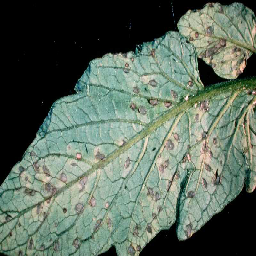

In [94]:
test_img = tf.keras.utils.load_img("tomato_not_use/Septoria_Leaf_Spot_of_Tomato187.jpg",
                                 target_size=(256,256),
                                
                                  )
test_img

In [100]:
input_arr = tf.keras.utils.img_to_array(test_img)
img_array = tf.expand_dims(input_arr, 0).numpy()
print(model.predict(img_array))
print(class_names[np.argmax(model.predict(img_array))])

1/1 [==============================] - 0s 26ms/step
[[3.7029926e-10 4.2358615e-02 9.5435905e-01 3.2821863e-03 6.4828420e-08
  1.8423792e-13 1.2828181e-11 7.1586676e-08 1.5437861e-15 2.6158633e-13]]
Tomato_Septoria_leaf_spot


In [127]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
model = load_model("tomatomo_model")

In [112]:
# temp = []
# for image_batch, labels_batch in test_ds:
#     temp.append(labels_batch.numpy())
# print(temp)

In [113]:
# y_predicted = model.predict(test_ds)
# predic = []
# for i in y_predicted:
#     predic.append(np.argmax(i))
#     print(np.argmax(i))
# # predic =[class_names[np.argmax(x)] for x in y_predicted]

In [115]:
# cm = tf.math.confusion_matrix(labels = temp ,predictions = predic)
# cm

In [114]:
# import seaborn as sn
# import matplotlib.pyplot as plt
# cm = tf.math.confusion_matrix(labels = test_ds,predictions =)
# plt.figure(figsize = (10,7))
# sn.heatmap(cm,annot= True ,fmt = 'd')
# plt.xlabel("Predicted")
# plt.ylabel("Truth")